# Noise attenuation


When using speech technology in realistic environments, such as at home,
office or in a car, there will invariably be also other sounds present
and not only the speech sounds of desired speaker. There will be the
background hum of computers and air conditioning, cars honking, other
speakers, and so on. Such sounds reduces the quality of the desired
signal, making it more strenuous to listen, more difficult to understand
or at the worst case, it might render the speech signal unintelligible.
A common feature of these sounds is however that they are *independent*
of and *uncorrelated* with the desired signal.

That is, we can usually assume that such noises are *additive*, such
that the observed signal $y$ is the sum of the desired signal $x$ and
interfering noises $v$, that is, $y=x+v$. To improve the quality of the
observed signal, we would like to make an estimate $ \hat x $ of
the desired signal $x$. The estimate should approximate the desired
signal $ x\approx \hat x $ or conversely, we would like to
minimize the distance $ d\left(x,\hat x\right) $ with some
distance measure $d(\cdot,\cdot)$.


![jezael-melgoza-KbR06h9dNQw-unsplash_scaled.png](attachments/175508067.png)
Photo by Jezael Melgoza on Unsplash

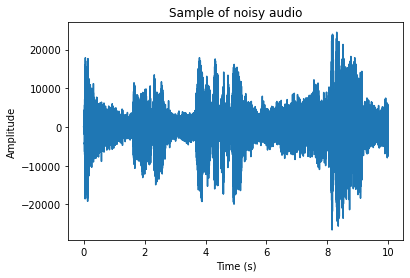

In [18]:
# Initialization for all
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from helper_functions import stft

fs = 44100  # Sample rate
seconds = 5  # Duration of recording

filename = 'sounds/enhancement_test.wav'


# read from storage
fs, data = wavfile.read(filename)
data = data[:]

t = np.arange(0,len(data),1)/fs
plt.plot(t,data)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Sample of noisy audio')
plt.show()

ipd.Audio(data,rate=fs)

## Classical methods

### Spectral subtraction

The [STFT spectrum](../Representations/Spectrogram_and_the_STFT.ipynb) of a signal is a good
domain for noise attenuation because we can reasonably safely assume
that spectral components are uncorrelated with each other, such that we
treat each component separately. In other words, in the spectrum, we can
apply noise attenuation on every frequency bin with scalar operations,
whereas if the components would be correlated, we would have to use
vector and matrix operations. The benefit of scalar operations is that
they are computationally simple, $O(N)$, whereas matrix operations are
typically at least $O(N^2)$.

The basic idea of spectral subtraction is that we assume that we have
access to an estimate of the noise energy $ E[\|v\|^2] = \sigma_v^2
$ , and we subtract that from the energy of the observation, such that
we define the energy of our estimate as

$$ \|\hat x\|^2 := \|y\|^2 - \sigma_v^2. $$

Unfortunately, since our estimate of noise energy is not perfect and
because we have hiddenly made an inaccurate assumption that $x$ and $v$
are uncorrelated, the above formula can give negative values for the
energy estimate. Negative energy is not realizable and nobody likes
pessimists, so we have to modify the formula to threshold at zero

$$ \|\hat x\|^2 := \begin{cases} \|y\|^2 - \sigma_v^2 & \text{if }
\|y\|^2 \geq \sigma_v^2 \\ 0 & \text{if } \|y\|^2 < \sigma_v^2
\end{cases}. $$

Since STFT spectra are complex-valued, we then still have to find the
complex angle of the signal estimate. If the noise energy is small $
\|v\|^2 \ll \|x\|^2 $ , then the complex angle of $x$ is
approximately equal to the angle of $y$, $ \angle x \approx \angle
y $ , such that our final estimate is (when $ \|y\|^2\geq
\sigma_v^2 $ )

$$ \hat x := \angle y \cdot \|\hat x\| = \frac{y}{\|y\|} \sqrt{
\|y\|^2 - \sigma_v^2} = y \sqrt{\frac{\|y\|^2 -
\sigma_v^2}{\|y\|^2}}. $$

Spectrograms of the original signal (above) and its enhanced version
obtained with spectral subtraction applied on the STFT (below)

<img src="attachments/172995194/175508704.png" class="image-center"
data-image-src="attachments/172995194/175508704.png"
data-unresolved-comment-count="0" data-linked-resource-id="175508704"
data-linked-resource-version="1" data-linked-resource-type="attachment"
data-linked-resource-default-alias="specsub_spectrogram.png"
data-base-url="https://wiki.aalto.fi"
data-linked-resource-content-type="image/png"
data-linked-resource-container-id="172995194"
data-linked-resource-container-version="33" height="400" />

  

Original noisy sample

<a href="attachments/172995194/175508733.wav"
data-linked-resource-id="175508733" data-linked-resource-version="1"
data-linked-resource-type="attachment"
data-linked-resource-default-alias="sound_sample.wav"
data-nice-type="Multimedia"
data-linked-resource-content-type="audio/x-wav"
data-linked-resource-container-id="172995194"
data-linked-resource-container-version="33">sound_sample.wav</a>

Enhanced with spectral subtraction

<a href="attachments/172995194/175508717.wav"
data-linked-resource-id="175508717" data-linked-resource-version="1"
data-linked-resource-type="attachment"
data-linked-resource-default-alias="sound_sample_specsub.wav"
data-nice-type="Multimedia"
data-linked-resource-content-type="audio/x-wav"
data-linked-resource-container-id="172995194"
data-linked-resource-container-version="33">sound_sample_specsub.wav</a>


#### Scalar Wiener filtering

Observe that the form of the relationship above is $ \hat x = y\cdot
g, $ where $g$ is a scalar scaling coefficient. Instead of the above
heuristic, we could then derive a formula which gives the smallest
error, for example in the minimum error energy expectation sense or
minimum mean square error (MMSE). Specifically, the error energy
expectation is

$$ E\left[\|e\|^2\right] = E\left[\|x-\hat x\|^2\right] =
E\left[\|x-gy\|^2\right] = E\left[\|x\|^2\right] + g^2
E\left[\|y\|^2\right] - 2g E\left[xy\right]. $$

If we assume that target speech and noise are uncorrelated, $
E\left[xv\right]=0 $ ,

then $
E\left[xy\right]=E\left[x(x+v)\right]=E\left[\|x\|^2\right]
$ and

$$ E\left[\|e\|^2\right] = E\left[\|x\|^2\right] + g^2
E\left[\|y\|^2\right] - 2g E\left[\|x\|^2\right] =
(1-2g)E\left[\|x\|^2\right] + g^2 E\left[\|y\|^2\right]. $$

The minimum is found by setting the derivative to zero

$$ 0 = \frac{\partial}{\partial g}E\left[\|e\|^2\right] =
-2E\left[\|x\|^2\right] + 2 g E\left[\|y\|^2\right], $$

such that the final solution is

$$ g = \frac{E\left[\|x\|^2\right]}{E\left[\|y\|^2\right]} =
\frac{E\left[\|y\|^2\right]-\sigma_v^2}{E\left[\|y\|^2\right]}.
$$

and the Wiener estimate becomes

$$ \hat x := y \left(\frac{\|y\|^2 - \sigma_v^2}{\|y\|^2}\right).
$$

Observe that this estimate is almost equal to the above, but the square
root is omitted. With different optimization criteria, we can easily
derive further such estimates. Such estimates have different weaknesses
and strengths and it is then a matter of application specific tuning to
choose the best estimate.

Overall, it is however somewhat unsatisfactory that *additive* noise is
attenuated with a *multiplicative* method. However, without a better
model of source and noise characteristics, this is probably the best we
can do. Still, spectral subtraction is a powerful method when taking
into account how simple it is. With minimal assumptions we obtain a
signal estimate which can give a clear improvement in quality.

</div>

</div>

<div class="cell normal" data-type="normal">

<div class="innerCell">

Spectrograms of the original signal (above) and its enhanced version
obtained with (scalar) Wiener filtering applied on the STFT (below)

<img src="attachments/172995194/175508702.png" class="image-center"
data-image-src="attachments/172995194/175508702.png"
data-unresolved-comment-count="0" data-linked-resource-id="175508702"
data-linked-resource-version="1" data-linked-resource-type="attachment"
data-linked-resource-default-alias="wiener_spectogram.png"
data-base-url="https://wiki.aalto.fi"
data-linked-resource-content-type="image/png"
data-linked-resource-container-id="172995194"
data-linked-resource-container-version="33" height="400" />

  

Enhanced with (scalar) Wiener filtering

<a href="attachments/172995194/175508720.wav"
data-linked-resource-id="175508720" data-linked-resource-version="1"
data-linked-resource-type="attachment"
data-linked-resource-default-alias="sound_sample_wiener.wav"
data-nice-type="Multimedia"
data-linked-resource-content-type="audio/x-wav"
data-linked-resource-container-id="172995194"
data-linked-resource-container-version="33">sound_sample_wiener.wav</a>


### Wiener filtering for vectors

Above we considered the scalar case, or conversely, the case where we
can treat components of a vector to be independent such that they can be
equivalently treated as a collection of scalars. In some cases, however,
we might be unable to find an uncorrelated representation of the signal
or the corresponding whitening process could be unfeasibly complex or it
can incur too much algorithmic delay. We then have to take into account
the correlation between components.

Consider for example a desired signal $ x\in{\mathbb R}^{N \times1}
$ , a noise signal $ v\in{\mathbb R}^{N \times1} $ and their
additive sum, the observation $ y = x+v, $ from which we want to
estimate the desired signal with a linear filter $ \hat x := a^H y.
$ Following the MMSE derivation above, we set the derivative of the
error energy expectation to zero

$$ \begin{split} 0&=\frac{\partial}{\partial
a}E\left[\|e\|^2\right] =\frac{\partial}{\partial
a}E\left[\|x-\hat x\|^2\right] =\frac{\partial}{\partial
a}E\left[\|x-a^H y\|^2\right] \\& =\frac{\partial}{\partial
a}E\left[\|x-a^H (x+v)\|^2\right] =2E\left[(x+v)\left(x-a^H
(x+v)\right)^H\right] \\& =2\left[ E[xx^H] - \left(E[xx^H] +
E[vv^H]\right)a\right] =2\left[ R_{xx} - \left(R_{xx} +
R_{vv}\right)a\right] \end{split} $$

Where the covariance matrices are $ R_{xx} = E[xx^H] $ and $
R_{vv} = E[vv^H] $ , and we used the fact that $x$ and $v$ are
uncorrelated $ E[xv^H]=0 $ . The solution is then clearly

$$ a=\left(R_{xx}+R_{vv}\right)^{-1} R_{xx} = R_{yy}^{-1}
\left(R_{yy}-R_{vv}\right), $$

where we for now assume that the inverse exists. This solution is
clearly similar to the MMSE solution for the scalar case.

A central weakness of this approach is that it involves a matrix
inversion, which is computationally complex operation, such that on-line
application is challenging. It furthermore requires that the covariance
matrix $R_{yy}$ is invertible (positive definite), which places
constraints on the methods for estimating such covariances.

In any case, Wiener filtering is a convenient method, because it
provides an analytical expression for an optimal solution in noise
attenuation. It consequently has very well documented properties and
performance guarantees.



## Speech presence estimation in noise attenuation

Our objective is to improve speech quality and we want enhance speech
which is corrupted by noise. Speech however is typically highly varying
in time and especially in a conversation, usually speakers do not speak
at the same time. Thus often one speaker is silent about half the time.
If there is no speech noise attenuation becomes trivial; Noise can be
removed by zeroing the whole signal.

To take advantage of such non-speech periods, we can use [voice activity
detection (VAD)](Voice_activity_detection_VAD_) to determine which parts
of the signal have speech and apply noise attenuation only there.
Paraphrasing, we have:


    If VAD(y) == Speech
       xhat = Enhance(y)
    else
       xhat = 0

This however requires that our voice activity detector is reliable also
for noisy speech signals, which is difficult. An alternative is to
estimate posteriori likelihoods as follows:

    xhat_noisyspeech = Enhance(y)
    vhat_noisyspeech = y - xhat_noisyspeech
    vhat_noiseonly = y
    SpeechLikelihood = PosterioriLikelihood(xhat_noisyspeech) * PosterioriLikelihood(vhat_noisyspeech) * PriorLikelihood(speech)
    NonspeechLikelihood = PosterioriLikelihood(vhat_noiseonly) * (1 - PriorLikelihood(speech)
    If SpeechLikelihood > NonspeechLikelihood
        xhat = xhat_noisyspeech
    else
        xhat = 0

This method thus always tries to attenuate noise and then looks at the
output whether "speech" or "non-speech" is more likely. Such hypothesis
testing is often useful but assumes that we have access to effective
likelihood estimators for both speech and noise.


Enhanced with (scalar) Wiener filtering and gated with VAD

<img src="attachments/172995194/175508726.png"
data-image-src="attachments/172995194/175508726.png"
data-unresolved-comment-count="0" data-linked-resource-id="175508726"
data-linked-resource-version="1" data-linked-resource-type="attachment"
data-linked-resource-default-alias="wiener_gated_spectrogram.png"
data-base-url="https://wiki.aalto.fi"
data-linked-resource-content-type="image/png"
data-linked-resource-container-id="172995194"
data-linked-resource-container-version="33" height="400" />

<a href="attachments/172995194/175508721.wav"
data-linked-resource-id="175508721" data-linked-resource-version="1"
data-linked-resource-type="attachment"
data-linked-resource-default-alias="sound_sample_wiener_gated.wav"
data-nice-type="Multimedia"
data-linked-resource-content-type="audio/x-wav"
data-linked-resource-container-id="172995194"
data-linked-resource-container-version="33">sound_sample_wiener_gated.wav</a>



## Masks, power spectra and temporal characteristics

As seen above, we can attenuate noise if we have a good estimate of the
noise energy. However, actually, both the spectral subtraction and
Wiener filtering methods use models of the speech and noise energies.
The models used above were rather heuristic; noise energy was assumed to
be "known" and speech energy was defined as energy of observation minus
noise energy. It is however not very difficult to make better models
than that. Before going to improved models, note that we did not use
speech and noise energies independently, but only their ratio. Now
clearly the ratio of speech and noise is the signal-to-noise ratio (SNR)
of that particular component. We thus obtain an estimate of the SNR of
the whole spectrum. Conversely, we would need only the SNR of the
spectrum to attenuate noise with the above methods. The SNR as a
function of frequency and time is often referred to as a *mask* and in
the following we will discuss some methods for generating such masks. It
is however important to understand that mask-based methods are operating
on the power (or magnitude) spectrum and thus do not include any models
of the complex phase. Indeed, efforts have in general focused mostly on
the power spectrum and much less on the phase. On one hand, the
motivation is that characteristics of the power spectrum are much more
important to perception than the phase (though the phase is also
important), but on the other hand, the power spectrum is also much
easier to work with than the phase. Therefore there has been both much
more demand and supply of methods which treat the power spectrum.

To model speech signals, we can begin by looking at spectral envelopes,
the high-level structure of the power spectrum. It is well-known that
the phonetic information of speech lies primarily in the shape of the
spectral envelope, and the lowest-frequency peaks of the envelope
identify the vowels uniquely. In other words, the distribution of
spectral energy varies smoothly across the frequencies. This is
something we can model and use to estimate the spectral mask. Similarly,
we know that phonemes vary slowly over time, which means that the
envelope varies slowly over time. Thus, again, we can model envelope
behaviour over time to generate spectral masks.

A variation of such masks is known as *binary* masks, where we can set,
for example, that the mask is 1 if speech energy is larger than noise
energy, and 0 otherwise. Clearly this is equivalent with thresholding
the SNR at unity (which is equivalent to 0 dB), such that an SNR-mask
can always be converted to a binary mask, but the reverse is not
possible. The benefit of binary masks is that it simplifies some
computations.

If we then want to attenuate noise in a particular frame of speech it is
then useful to use as much of the surrounding data (context) as
possible. For best quality, we can model, say, a second of the speech
signal both before and after the target frame. Though this can improve
quality of the estimate, this has two clear negative consequences. First
of all, including more data increases computational complexity. The
level of acceptable complexity is though highly dependent on the
application. Secondly, if we look into *future* frames to process the
current frame, then we have to have access to such data. In a on-line
system, this means that we have to wait for the whole look-ahead data to
arrive before processing, such that the overall system has a delay
corresponding to the length of the look-ahead. We can extrapolate the
current frame from past frames, but interpolating between past and
future frames does give much better quality. The amount of acceptable
delay is also an application dependent question.



## Machine learning methods

The first choice in designing machine learning methods for noise
attenuation and other speech enhancement tasks is the overall systems
architecture. The application is usually simply a neural network which
takes noisy speech as input and outputs an estimate of the clean speech.
A natural choice would then be to train the network with a large
database of noisy speech samples and minimize the distance of the output
to the clean speech signal. Since we assume that noise is additive, we
can create synthetic samples by adding noise to speech. By varying the
intensity (volume) of the noise samples, we can further choose the
signal to noise ratio of the noise samples. With reasonable size
databases of speech and noise, we thus get a practically infinite number
of unique noisy samples such that we can make even a large neural
network to converge.

A weakness of this model however is that even if the database is thus
large, it has only a limited number of unique noises and unique
speakers. There is no easy way of getting assurance that unseen noises
and speakers would be enhanced effectively. What if we receive a noisy
sample where a 3 year-old child talks with annoying
[vuvuzelas](https://en.wikipedia.org/wiki/Vuvuzela) playing in the
background. If our database contained only adult speakers and did not
contain vuvuzela-sounds, then we cannot know whether our enhancement is
effective on the noisy sample.



Machine learning configuration for speech enhancement with noisy and
target clean speech signal.


![speechenhancement1](attachments/175508243.png)



To overcome the problem of inadequate noise databases, we can take an
*adversarial* approach, where we have a *generative* network which
generates noises and an enhancement network which attenuates noises
which corrupt speech. This approach is known as a *generative
adversarial network (GAN)*. We then have two optimization tasks;

1.  To optimize the enhancement network (minimize estimation error) to
    remove the noise generated by the generative network and
2.  to optimize the generative network (maximize estimation error) to
    generate noises which the enhancement network is unable to remove.

These two tasks are adversial in the sense that they work against each
other. In practical application we would use only the enhancement
network, so the generative network is used only in training.



Application and training with a generative adversarial network (GAN)
structure for speech enhancement.

    
![speechenhancement2](attachments/175508259.png)